In [5]:
import gc, os, random, pickle
import pandas as pd
import numpy as np
import scipy
from scipy import stats

# 导入模型和sklearn
import xgboost as xgb
import lightgbm as lgb
import catboost as cat
from lightgbm import LGBMClassifier, LGBMRegressor
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn.metrics import roc_auc_score, accuracy_score,auc, log_loss
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from tqdm import tqdm 
import warnings
warnings.filterwarnings("ignore")


pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', 200)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)
    
'''seaborn and matplotlib'''
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

'''plotly'''
import plotly.offline as py
from plotly.offline import iplot, init_notebook_mode
import plotly.graph_objs as go

'''按markdown格式展现数据'''
init_notebook_mode(connected = True)
from IPython.display import Markdown

def bold(string):
    display(Markdown(string))

/Users/baixiaoling/opt/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


# EDA

In [1]:
train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test =pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

NameError: name 'pd' is not defined

In [2]:
print(train.shape, test.shape)

NameError: name 'train' is not defined

In [3]:
train.head(2)

NameError: name 'train' is not defined

In [4]:
test.head(2)

NameError: name 'test' is not defined

In [6]:
print(train['label'].value_counts())
# 21 多一点外，其他几类基本上差不多

21    358600
1     261207
4     260186
5     254562
Name: label, dtype: int64


In [7]:
train.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1134555 entries, 0 to 1134554
Data columns (total 9 columns):
jet_id                             1134555 non-null object
number_of_particles_in_this_jet    1134555 non-null int64
jet_px                             1134555 non-null float64
jet_py                             1134555 non-null float64
jet_pz                             1134555 non-null float64
jet_energy                         1134555 non-null float64
jet_mass                           1134555 non-null float64
event_id                           1134555 non-null object
label                              1134555 non-null int64
dtypes: float64(5), int64(2), object(2)
memory usage: 77.9+ MB


In [8]:
# 缺失值分析
# all_missing_columns = train.columns[train.isnull().sum() == train.shape[0]]
train.isnull().sum() # 没有缺失值

jet_id                             0
number_of_particles_in_this_jet    0
jet_px                             0
jet_py                             0
jet_pz                             0
jet_energy                         0
jet_mass                           0
event_id                           0
label                              0
dtype: int64

In [9]:
onlyone_val_columns = train.columns[train.nunique(axis=0) == 1]

print('共有 %i 个特征列仅仅只包含一个元素之，' % len(onlyone_val_columns))

print('这些特征列为: ',onlyone_val_columns )

共有 0 个特征列仅仅只包含一个元素之，
这些特征列为:  Index([], dtype='object')


In [10]:
train.describe()

,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,label
count,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06,1.134555e+06
mean,2.141576e+01,-1.262110e-02,9.496788e-04,1.830779e-03,1.592155e+02,1.357930e+01,8.906894e+00
std,1.226341e+01,2.025569e+02,2.944280e+01,2.802875e+01,1.328982e+02,1.205523e+01,8.340469e+00
min,1.000000e+00,-4.984470e+02,-4.160350e+02,-4.270560e+02,1.004080e+01,-5.642010e-06,1.000000e+00
25%,1.200000e+01,-1.072530e+02,-5.802830e+00,-5.108620e+00,4.049085e+01,4.959175e+00,4.000000e+00
50%,1.900000e+01,1.473780e-01,-1.807420e-03,1.853660e-03,1.198290e+02,1.007730e+01,5.000000e+00
75%,2.800000e+01,1.071365e+02,5.820565e+00,5.157565e+00,2.574340e+02,1.802500e+01,2.100000e+01
max,1.090000e+02,4.987270e+02,4.383140e+02,3.900830e+02,5.003970e+02,1.171720e+02,2.100000e+01


In [11]:
def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
train[train['jet_mass'] < 0].shape # 共有652个值 质量为负， 可以填充为0 或者直接删除
# test[train['jet_mass'] < 0].shape #
train['jet_mass']  = train['jet_mass'].map(lambda x : replace(x))
train['jet_energy']  = train['jet_energy'].map(lambda x : replace(x))

In [12]:
train[train['jet_mass'] < 0].head(100)
# train.head(2)

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label


In [13]:
train.loc[train['jet_mass'] < 0]= 0 

In [14]:
train[train['label'] <= 0].head()

,jet_id,number_of_particles_in_this_jet,jet_px,jet_py,jet_pz,jet_energy,jet_mass,event_id,label


# 特征工程

## 加载数据 & 减少内存占用



In [6]:


train = pd.read_csv('./jet_simple_data/simple_train_R04_jet.csv')
test= pd.read_csv('./jet_simple_data/simple_test_R04_jet.csv')

# train = pd.read_csv('./jet_simple_data/simple_train_R04_jet_10000.csv')
# test= pd.read_csv('./jet_simple_data/simple_test_R04_jet_10000.csv')

data = train.append(test)
print('data shape: ', data.shape)

def replace(x) :
    if x < 0.0:
        return 0
    else:
        return x
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data['jet_mass']  = data['jet_mass'].map(lambda x : replace(x))
data['jet_energy']  = data['jet_energy'].map(lambda x : replace(x))
print(data[data['jet_mass'] < 0].shape, data[data['jet_energy'] < 0].shape)

data shape:  (1672504, 9)
(977, 9) (0, 9)
(0, 9) (0, 9)


In [7]:
data.head()

,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,1.0,21
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,5.0,26
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,4.0,27
3,a0543408ffe140979e03b063fd7129c5,286.0620,d3b2474fe3ba43e2b02b918adf8bbd98,26.71040,284.8090,1.31363,0.562324,1.0,17
4,a4b2679fd14a418c8d21fcaf2e32be8e,42.2007,e46253f34c93428cb91fe0c7fc03c430,3.55142,-38.3067,15.60110,-7.581700,4.0,12


In [8]:
# 根据坐标求方位

# def get_direction(px, py, pz):
# #     print(px, py, pz)
#     if px > 0:
#         if py > 0:
#             if pz > 0:
#                 return 1
#             else:
#                 return 2
#         else:
#             if pz > 0:
#                 return 3
#             else:
#                 return 4
#     else:
#         if py > 0:
#             if pz > 0:
#                 return 5
#             else:
#                 return 6
#         else:
#             if pz > 0:
#                 return 7
#             else:
#                 return 8
def count_column(df,column):
    tp = df.groupby(column).count().reset_index()
    tp = tp[list(tp.columns)[0:2]]
    tp.columns = [column, column+'_count']
    df=df.merge(tp,on=column,how='left')
    return df
def count_mean(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['mean']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_mean']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_count(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['count']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_count']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_sum(df,base_column,count_column):
    tp = df.groupby(base_column).agg({count_column: ['sum']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_sum']
    df = df.merge(tp, on=base_column, how='left')
    return df
def count_std(df,base_column,count_column):
#     tp = df.groupby(base_column)[[count_column]].std()
    tp = df.groupby(base_column).agg({count_column: ['std']}).reset_index()
    tp.columns = [base_column, base_column+'_'+count_column+'_std']
    df = df.merge(tp, on=base_column, how='left')
    return df


def get_mean_sum_std(df, base_column, count_column):
    df = count_mean(df, base_column, count_column)
    df = count_std(df, base_column, count_column)
    df = count_sum(df, base_column, count_column)
    
    return df

def energy(df):
    x=df['jet_px']
    y=df['jet_py']
    z= df['jet_pz']
    return (x**2+y**2+z**2)**0.5

def get_feature(data_):
    
    # 能方向特征
    data = data_.copy()
    data['energy'] = data.apply(energy, axis =1)
    data['x_n']=data['jet_px']/data['energy']
    data['y_n']=data['jet_py']/data['energy']
    data['z_n']=data['jet_pz']/data['energy']
    
    data['abs'] = data['jet_energy'] - data['energy']
    data['mean_jet_energy'] = data['jet_energy'] /data['number_of_particles_in_this_jet']
    data['mean_jet_mass'] = data['jet_mass'] /data['number_of_particles_in_this_jet']
    data['energy_mass'] = data['jet_energy']/ data['jet_mass']
    
    data = get_mean_sum_std(data, 'event_id', 'x_n')
    data = get_mean_sum_std(data, 'event_id', 'y_n')
    data = get_mean_sum_std(data, 'event_id', 'z_n')
    
    data = get_mean_sum_std(data, 'event_id', 'number_of_particles_in_this_jet')
    data = get_mean_sum_std(data, 'event_id', 'jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'abs')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_energy')
    data = get_mean_sum_std(data, 'event_id', 'mean_jet_mass')
    data = get_mean_sum_std(data, 'event_id', 'energy_mass')
    data = get_mean_sum_std(data, 'event_id', 'energy')
    
    
    
     # event 统计特征
    evnet_jetnum_data = pd.DataFrame({"event_jet_num": data.groupby('event_id')['jet_id'].count()})
    data = data.merge(evnet_jetnum_data, on='event_id', how='left')
    return data

In [9]:
data_new = get_feature(data)

In [10]:
print(data_new.shape)
data_new.head()

(1672504, 51)


,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet,energy,x_n,y_n,z_n,abs,mean_jet_energy,mean_jet_mass,energy_mass,event_id_x_n_mean,event_id_x_n_std,event_id_x_n_sum,event_id_y_n_mean,event_id_y_n_std,event_id_y_n_sum,event_id_z_n_mean,event_id_z_n_std,event_id_z_n_sum,event_id_number_of_particles_in_this_jet_mean,event_id_number_of_particles_in_this_jet_std,event_id_number_of_particles_in_this_jet_sum,event_id_jet_mass_mean,event_id_jet_mass_std,event_id_jet_mass_sum,event_id_jet_energy_mean,event_id_jet_energy_std,event_id_jet_energy_sum,event_id_abs_mean,event_id_abs_std,event_id_abs_sum,event_id_mean_jet_energy_mean,event_id_mean_jet_energy_std,event_id_mean_jet_energy_sum,event_id_mean_jet_mass_mean,event_id_mean_jet_mass_std,event_id_mean_jet_mass_sum,event_id_energy_mass_mean,event_id_energy_mass_std,event_id_energy_mass_sum,event_id_energy_mean,event_id_energy_std,event_id_energy_sum,event_jet_num
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,1.0,21,288.518024,-0.999979,0.001049,0.006376,0.547976,13.765048,0.846719,16.256924,-0.000175,1.413936,-0.000351,0.001267,0.000309,0.002534,-0.010419,0.023752,-0.020838,19.500000,2.121320,39,15.381200,3.393971,30.76240,293.614000,6.431843,587.2280,0.415161,0.187829,0.830323,15.164802,1.979551,30.329603,0.783951,0.088767,1.567902,19.612751,4.745856,39.225502,293.198839,6.619672,586.397677,2
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,5.0,26,159.296786,-0.994672,0.013388,-0.102221,0.421214,6.143000,0.445569,13.786859,0.001066,1.408186,0.002132,-0.023474,0.052131,-0.046949,-0.024926,0.109311,-0.049852,30.000000,5.656854,60,13.487200,2.690400,26.97440,154.390000,7.534930,308.7800,0.609137,0.265763,1.218274,5.263588,1.243676,10.527176,0.449102,0.004996,0.898205,11.736375,2.899821,23.472750,153.780863,7.800693,307.561726,2
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,4.0,27,112.522808,-0.925528,-0.331197,-0.183594,0.797192,4.197037,0.497100,8.443044,-0.345535,0.923397,-1.382142,0.128148,0.407599,0.512590,0.093605,0.348947,0.374419,20.500000,5.916080,82,9.972905,5.437937,39.89162,98.016750,64.323257,392.0670,0.519361,0.259773,2.077444,4.496670,2.191263,17.986680,0.460754,0.156773,1.843018,9.465790,1.465046,37.863161,97.497389,64.115402,389.989556,4
3,a0543408ffe140979e03b063fd7129c5,286.0620,d3b2474fe3ba43e2b02b918adf8bbd98,26.71040,284.8090,1.31363,0.562324,1.0,17,284.812585,0.999987,0.004612,0.001974,1.249415,16.827176,1.571200,10.709761,0.000041,1.414138,0.000081,0.003245,0.001934,0.006489,0.007774,0.008202,0.015548,20.000000,4.242641,40,18.687600,11.345953,37.37520,282.751500,4.681754,565.5030,0.726599,0.739374,1.453197,14.488393,3.307540,28.976785,1.017443,0.783130,2.034887,18.455970,10.954794,36.911940,282.024901,3.942380,564.049803,2
4,a4b2679fd14a418c8d21fcaf2e32be8e,42.2007,e46253f34c93428cb91fe0c7fc03c430,3.55142,-38.3067,15.60110,-7.581700,4.0,12,42.050919,-0.910960,0.371005,-0.180298,0.149781,3.516725,0.295952,11.882768,-0.302851,1.129067,-0.908552,0.104765,0.233168,0.314294,-0.053140,0.112091,-0.159419,18.333333,10.969655,55,10.613690,9.615293,31.84107,198.735567,136.434186,596.2067,0.344173,0.393574,1.032520,11.583246,9.329979,34.749738,0.517342,0.203292,1.552025,21.446903,15.136895,64.340708,198.391393,136.227188,595.174180,3


In [11]:
data_new.columns

Index(['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py',
       'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x_n',
       'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass',
       'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum',
       'event_id_y_n_mean', 'event_id_y_n_std', 'event_id_y_n_sum',
       'event_id_z_n_mean', 'event_id_z_n_std', 'event_id_z_n_sum',
       'event_id_number_of_particles_in_this_jet_mean',
       'event_id_number_of_particles_in_this_jet_std',
       'event_id_number_of_particles_in_this_jet_sum',
       'event_id_jet_mass_mean', 'event_id_jet_mass_std',
       'event_id_jet_mass_sum', 'event_id_jet_energy_mean',
       'event_id_jet_energy_std', 'event_id_jet_energy_sum',
       'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum',
       'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_std',
       'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean',
       'e

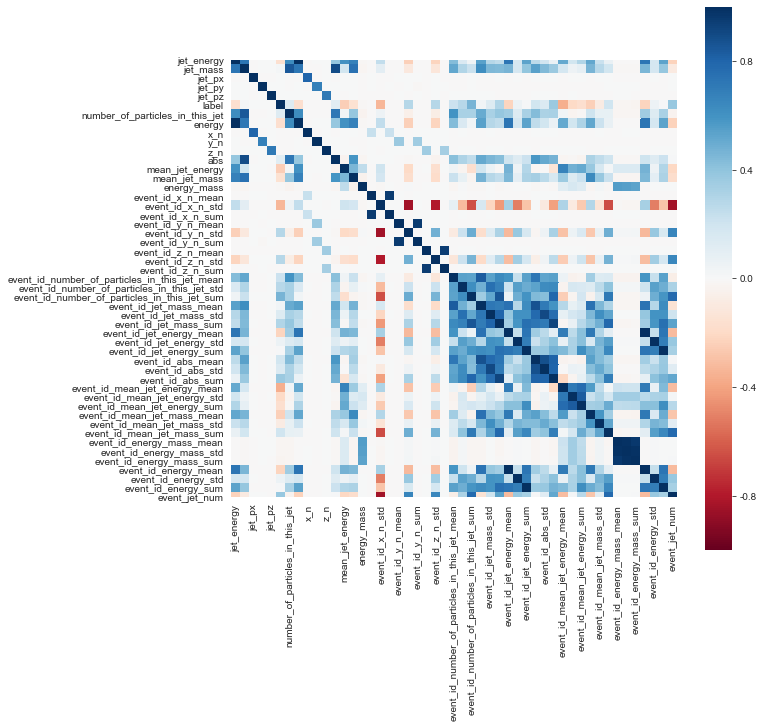

In [12]:
plt.rcParams['figure.figsize'] = (10,10)
sns.heatmap(data_new.corr(), vmin=-1, vmax=1, center=0, 
            square=True, cmap='RdBu') #cmap = sns.diverging_palette(20, 220, n=200))
plt.show()

# 模型训练

In [13]:
tr_index = ~data_new['label'].isnull()
train = data_new[tr_index].reset_index(drop=True)
y = data_new[tr_index]['label'].reset_index(drop=True).astype(int)
test = data_new[~tr_index].reset_index(drop=True)
print(train.shape,test.shape)



(1134555, 51) (537949, 51)


In [14]:
# from sklearn.preprocessing import LabelEncoder
# object_col = ['label']
# for i in tqdm(object_col):
#     lbl = LabelEncoder()
#     train[i] = lbl.fit_transform(train[i].astype(str))

d={1:0,4:1,5:2,21:3}
def label_process(x):
    x=d[x]
    return x
train['label']=train['label'].apply(label_process)

In [15]:
train.head()

,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet,energy,x_n,y_n,z_n,abs,mean_jet_energy,mean_jet_mass,energy_mass,event_id_x_n_mean,event_id_x_n_std,event_id_x_n_sum,event_id_y_n_mean,event_id_y_n_std,event_id_y_n_sum,event_id_z_n_mean,event_id_z_n_std,event_id_z_n_sum,event_id_number_of_particles_in_this_jet_mean,event_id_number_of_particles_in_this_jet_std,event_id_number_of_particles_in_this_jet_sum,event_id_jet_mass_mean,event_id_jet_mass_std,event_id_jet_mass_sum,event_id_jet_energy_mean,event_id_jet_energy_std,event_id_jet_energy_sum,event_id_abs_mean,event_id_abs_std,event_id_abs_sum,event_id_mean_jet_energy_mean,event_id_mean_jet_energy_std,event_id_mean_jet_energy_sum,event_id_mean_jet_mass_mean,event_id_mean_jet_mass_std,event_id_mean_jet_mass_sum,event_id_energy_mass_mean,event_id_energy_mass_std,event_id_energy_mass_sum,event_id_energy_mean,event_id_energy_std,event_id_energy_sum,event_jet_num
0,410e86bc0457482d9d6f81cd2d95ccf0,289.0660,17a0a1f19a7f43558cb9cca517b6e198,17.78110,-288.5120,0.30256,1.839620,0,21,288.518024,-0.999979,0.001049,0.006376,0.547976,13.765048,0.846719,16.256924,-0.000175,1.413936,-0.000351,0.001267,0.000309,0.002534,-0.010419,0.023752,-0.020838,19.500000,2.121320,39,15.381200,3.393971,30.76240,293.614000,6.431843,587.2280,0.415161,0.187829,0.830323,15.164802,1.979551,30.329603,0.783951,0.088767,1.567902,19.612751,4.745856,39.225502,293.198839,6.619672,586.397677,2
1,6f7bf9104f8c4a619eedd129d5ce3dcb,159.7180,36d1005f56d343d5a09513cb7a4ead61,11.58480,-158.4480,2.13265,-16.283400,2,26,159.296786,-0.994672,0.013388,-0.102221,0.421214,6.143000,0.445569,13.786859,0.001066,1.408186,0.002132,-0.023474,0.052131,-0.046949,-0.024926,0.109311,-0.049852,30.000000,5.656854,60,13.487200,2.690400,26.97440,154.390000,7.534930,308.7800,0.609137,0.265763,1.218274,5.263588,1.243676,10.527176,0.449102,0.004996,0.898205,11.736375,2.899821,23.472750,153.780863,7.800693,307.561726,2
2,4ee694b125c944c1a4560a20b79ccbe3,113.3200,a82071a653304481979b5dfb8eb0da47,13.42170,-104.1430,-37.26720,-20.658500,1,27,112.522808,-0.925528,-0.331197,-0.183594,0.797192,4.197037,0.497100,8.443044,-0.345535,0.923397,-1.382142,0.128148,0.407599,0.512590,0.093605,0.348947,0.374419,20.500000,5.916080,82,9.972905,5.437937,39.89162,98.016750,64.323257,392.0670,0.519361,0.259773,2.077444,4.496670,2.191263,17.986680,0.460754,0.156773,1.843018,9.465790,1.465046,37.863161,97.497389,64.115402,389.989556,4
3,a0543408ffe140979e03b063fd7129c5,286.0620,d3b2474fe3ba43e2b02b918adf8bbd98,26.71040,284.8090,1.31363,0.562324,0,17,284.812585,0.999987,0.004612,0.001974,1.249415,16.827176,1.571200,10.709761,0.000041,1.414138,0.000081,0.003245,0.001934,0.006489,0.007774,0.008202,0.015548,20.000000,4.242641,40,18.687600,11.345953,37.37520,282.751500,4.681754,565.5030,0.726599,0.739374,1.453197,14.488393,3.307540,28.976785,1.017443,0.783130,2.034887,18.455970,10.954794,36.911940,282.024901,3.942380,564.049803,2
4,a4b2679fd14a418c8d21fcaf2e32be8e,42.2007,e46253f34c93428cb91fe0c7fc03c430,3.55142,-38.3067,15.60110,-7.581700,1,12,42.050919,-0.910960,0.371005,-0.180298,0.149781,3.516725,0.295952,11.882768,-0.302851,1.129067,-0.908552,0.104765,0.233168,0.314294,-0.053140,0.112091,-0.159419,18.333333,10.969655,55,10.613690,9.615293,31.84107,198.735567,136.434186,596.2067,0.344173,0.393574,1.032520,11.583246,9.329979,34.749738,0.517342,0.203292,1.552025,21.446903,15.136895,64.340708,198.391393,136.227188,595.174180,3


In [16]:
test.head()

,event_id,jet_energy,jet_id,jet_mass,jet_px,jet_py,jet_pz,label,number_of_particles_in_this_jet,energy,x_n,y_n,z_n,abs,mean_jet_energy,mean_jet_mass,energy_mass,event_id_x_n_mean,event_id_x_n_std,event_id_x_n_sum,event_id_y_n_mean,event_id_y_n_std,event_id_y_n_sum,event_id_z_n_mean,event_id_z_n_std,event_id_z_n_sum,event_id_number_of_particles_in_this_jet_mean,event_id_number_of_particles_in_this_jet_std,event_id_number_of_particles_in_this_jet_sum,event_id_jet_mass_mean,event_id_jet_mass_std,event_id_jet_mass_sum,event_id_jet_energy_mean,event_id_jet_energy_std,event_id_jet_energy_sum,event_id_abs_mean,event_id_abs_std,event_id_abs_sum,event_id_mean_jet_energy_mean,event_id_mean_jet_energy_std,event_id_mean_jet_energy_sum,event_id_mean_jet_mass_mean,event_id_mean_jet_mass_std,event_id_mean_jet_mass_sum,event_id_energy_mass_mean,event_id_energy_mass_std,event_id_energy_mass_sum,event_id_energy_mean,event_id_energy_std,event_id_energy_sum,event_jet_num
0,63d5670e5c514f00b64c0329382af524,87.5486,cb3b5c6ea5e441e9b425fc1e6a4a00e6,7.39969,-86.9773,0.268724,6.699850,NaN,23,87.235377,-0.997042,0.003080,0.076802,0.313223,3.806461,0.321726,11.831388,0.001418,1.412035,0.002837,0.005273,0.003100,0.010545,0.031545,0.064003,0.063090,18.500000,6.363961,37,6.943580,0.645037,13.88716,78.772300,12.411562,157.5446,0.307265,0.008427,0.614530,4.403088,0.843758,8.806175,0.392558,0.100172,0.785116,11.310401,0.736787,22.620802,78.465035,12.403136,156.930070,2
1,8ddc9b4f189d42d08bde2936914341ed,73.2549,838bf5c3f9bc4a2194f51b3c57f403cd,11.06970,72.0487,-7.242040,-0.515331,NaN,26,72.413589,0.994961,-0.100009,-0.007116,0.841311,2.817496,0.425758,6.617605,-0.228182,0.821993,-0.912729,-0.218529,0.496112,-0.874117,0.152032,0.497613,0.608128,12.750000,9.287088,51,5.205082,4.319445,20.82033,43.124425,27.738854,172.4977,0.351558,0.350301,1.406233,3.497367,1.032787,13.989468,0.371828,0.145519,1.487310,11.431917,7.241554,45.727667,42.772867,27.475835,171.091467,4
2,e9a3a2a70f8f45999a0526c9b7538670,21.6806,fbc245d8b90b4a5d804880e097244a67,3.09542,21.4055,-0.877366,-1.224690,NaN,6,21.458450,0.997532,-0.040887,-0.057073,0.222150,3.613433,0.515903,7.004090,0.329457,1.052842,0.988370,0.001208,0.329857,0.003623,-0.041082,0.342596,-0.123245,11.000000,4.358899,33,5.536200,2.117056,16.60860,44.171333,21.404547,132.5140,0.355521,0.127363,1.066562,3.928608,0.575035,11.785824,0.505869,0.013117,1.517607,7.789004,1.354025,23.367011,43.815813,21.321919,131.447438,3
3,e8f3cdee49b043a08be537c763e8e2f4,13.3144,f4c5dffa513a443fbbd27ca4c0fbe44f,1.28673,-12.1341,-3.029840,-4.381850,NaN,7,13.252054,-0.915639,-0.228632,-0.330654,0.062346,1.902057,0.183819,10.347470,-0.203207,0.888708,-1.016033,-0.077262,0.504652,-0.386309,-0.123164,0.357051,-0.615822,16.600000,5.941380,83,7.327930,4.022064,36.63965,52.599920,24.095462,262.9996,0.543047,0.388175,2.715234,3.009274,0.715218,15.046368,0.407264,0.146914,2.036319,7.978494,2.273870,39.892471,52.056873,23.839669,260.284366,5
4,757c56889e744eff99611d8313ca31f7,266.3240,74b105d4cb654c4d94da3fb88c8cd6a7,12.38630,133.2230,203.498000,-107.776000,NaN,17,266.036595,0.500769,0.764925,-0.405117,0.287405,15.666118,0.728606,21.501498,-0.147893,0.770506,-0.443678,-0.046469,0.823283,-0.139407,0.027228,0.437454,0.081683,31.333333,13.203535,94,17.246867,4.475012,51.74060,239.867000,51.993287,719.6010,0.714613,0.492021,2.143840,9.296644,5.842913,27.889932,0.585201,0.125884,1.755604,15.014545,6.505546,45.043636,239.152387,52.447827,717.457160,3


In [17]:
train.columns

Index(['event_id', 'jet_energy', 'jet_id', 'jet_mass', 'jet_px', 'jet_py',
       'jet_pz', 'label', 'number_of_particles_in_this_jet', 'energy', 'x_n',
       'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass',
       'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum',
       'event_id_y_n_mean', 'event_id_y_n_std', 'event_id_y_n_sum',
       'event_id_z_n_mean', 'event_id_z_n_std', 'event_id_z_n_sum',
       'event_id_number_of_particles_in_this_jet_mean',
       'event_id_number_of_particles_in_this_jet_std',
       'event_id_number_of_particles_in_this_jet_sum',
       'event_id_jet_mass_mean', 'event_id_jet_mass_std',
       'event_id_jet_mass_sum', 'event_id_jet_energy_mean',
       'event_id_jet_energy_std', 'event_id_jet_energy_sum',
       'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum',
       'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_std',
       'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean',
       'e

In [18]:
train_features =['jet_energy', 'jet_mass', 'jet_px', 'jet_py',
       'jet_pz','number_of_particles_in_this_jet', 'energy', 'x_n',
       'y_n', 'z_n', 'abs', 'mean_jet_energy', 'mean_jet_mass', 'energy_mass',
       'event_id_x_n_mean', 'event_id_x_n_std', 'event_id_x_n_sum',
       'event_id_y_n_mean', 'event_id_y_n_std', 'event_id_y_n_sum',
       'event_id_z_n_mean', 'event_id_z_n_std', 'event_id_z_n_sum',
       'event_id_number_of_particles_in_this_jet_mean',
       'event_id_number_of_particles_in_this_jet_std',
       'event_id_number_of_particles_in_this_jet_sum',
       'event_id_jet_mass_mean', 'event_id_jet_mass_std',
       'event_id_jet_mass_sum', 'event_id_jet_energy_mean',
       'event_id_jet_energy_std', 'event_id_jet_energy_sum',
       'event_id_abs_mean', 'event_id_abs_std', 'event_id_abs_sum',
       'event_id_mean_jet_energy_mean', 'event_id_mean_jet_energy_std',
       'event_id_mean_jet_energy_sum', 'event_id_mean_jet_mass_mean',
       'event_id_mean_jet_mass_std', 'event_id_mean_jet_mass_sum',
       'event_id_energy_mass_mean', 'event_id_energy_mass_std',
       'event_id_energy_mass_sum', 'event_id_energy_mean',
       'event_id_energy_std', 'event_id_energy_sum', 'event_jet_num']
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, classification_report, roc_auc_score
from sklearn.preprocessing import label_binarize
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from tqdm import tqdm
    
folds = 5
seed = 2019
kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=seed)

models = []

results = np.zeros((len(test), 4), dtype='float')

for index, (train_index, valid_index) in tqdm(enumerate(kf.split(train, train['label']))):
    print("交叉验证: {} / {}".format( index+1, folds))
    X_train = train.iloc[train_index][train_features]
    X_valid = train.iloc[valid_index][train_features]
    Y_train =train['label'].iloc[train_index]
    Y_valid = train['label'].iloc[valid_index]
    
    model = CatBoostClassifier(
        iterations=4000 ,
        loss_function='MultiClass',
        eval_metric = 'Accuracy',
        verbose=100,
        learning_rate=0.1, 
        max_depth=6, 
        l2_leaf_reg=9, 
        early_stopping_rounds=50, 
    )
    model.fit(X_train, Y_train, eval_set=(X_valid, Y_valid), use_best_model=True)

    valid_pred = model.predict_proba(X_valid)
    results += model.predict_proba(test[train_features])
    
    valid_pred = valid_pred.argmax(axis=1)
    print('分类报告：\n',classification_report(Y_valid , valid_pred))
   
    
pred =results.argmax(axis=1)
d={1:0,4:1,5:2,21:3}

d={0:1,1:4,2:5,3:21}
out = [d[x] for x in pred]
submission = pd.read_csv('./jet_simple_data/sample_submmission.csv')
submission['label'] = out
submission.to_csv('./result/baseline-1219-02.csv', index=False)


0it [00:00, ?it/s]

交叉验证: 1 / 5
0:	learn: 0.4573642	test: 0.4577349	best: 0.4577349 (0)	total: 1.43s	remaining: 1h 35m 21s
100:	learn: 0.5268586	test: 0.5258976	best: 0.5259461 (97)	total: 2m 6s	remaining: 1h 21m 25s
200:	learn: 0.5333557	test: 0.5316487	best: 0.5316487 (200)	total: 3m 56s	remaining: 1h 14m 35s
300:	learn: 0.5379434	test: 0.5349275	best: 0.5349495 (299)	total: 5m 45s	remaining: 1h 10m 45s
400:	learn: 0.5416805	test: 0.5379859	best: 0.5379859 (400)	total: 7m 21s	remaining: 1h 6m
500:	learn: 0.5452238	test: 0.5404538	best: 0.5404538 (500)	total: 9m 15s	remaining: 1h 4m 42s
600:	learn: 0.5487130	test: 0.5427146	best: 0.5427146 (600)	total: 10m 49s	remaining: 1h 1m 10s
700:	learn: 0.5518079	test: 0.5450239	best: 0.5450239 (700)	total: 12m 33s	remaining: 59m 5s
800:	learn: 0.5550272	test: 0.5465795	best: 0.5466104 (795)	total: 14m 45s	remaining: 58m 56s
900:	learn: 0.5577133	test: 0.5482762	best: 0.5483159 (897)	total: 16m 51s	remaining: 57m 58s
1000:	learn: 0.5601823	test: 0.5498407	best: 0.5

KeyboardInterrupt: 

In [ ]:
#  迭代2000论， 5折： 0.6749447085072
#  但看迭代还在一直提升

**catboost特征重要性**

[0.44038597 0.25630469 0.11767915 0.32847924 0.16412297 0.70940832
 0.3647808  2.50095239 0.08937069 0.12327154 0.93914746 0.28530475
 0.4612954  0.37862002 1.45915107 6.22456353 1.10154951 1.17056126
 1.82894648 1.45449658 1.29597251 3.04231703 1.28086753 5.67054522
 3.40067748 9.26989394 1.14632991 1.63197594 0.81623987 0.70231601
 4.13706306 0.9605856  1.72046916 1.89890636 2.6824739  6.10202689
 6.14972494 1.88086955 3.48510223 2.13872604 2.51953232 5.10313197
 3.54278444 1.33394239 0.80600592 5.21304872 0.99992884 0.6701504 ]
[('event_id_number_of_particles_in_this_jet_sum', 9.26989393980912), ('event_id_x_n_std', 6.22456352839404), ('event_id_mean_jet_energy_std', 6.149724935483112), ('event_id_mean_jet_energy_mean', 6.102026890829852), ('event_id_number_of_particles_in_this_jet_mean', 5.670545222175964), ('event_id_energy_std', 5.213048723237725), ('event_id_energy_mass_mean', 5.103131971628442), ('event_id_jet_energy_std', 4.137063057438342), ('event_id_energy_mass_std', 3.5427

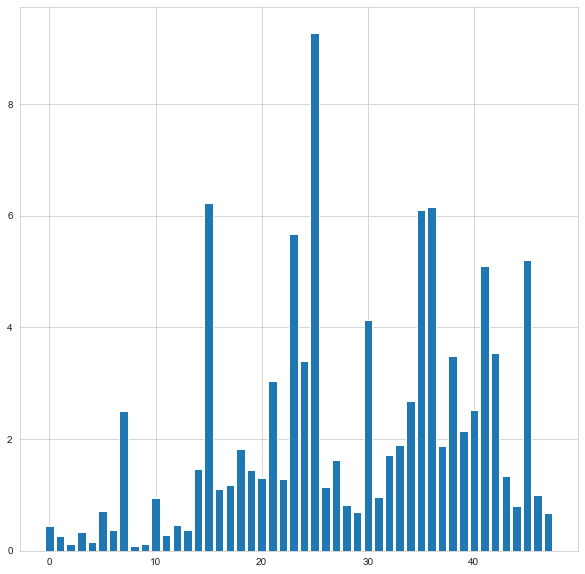

In [223]:
bold("**catboost特征重要性**")
print(model.feature_importances_)
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
feature_important = dict(zip(train_features, model.feature_importances_))
feature_important=sorted(feature_important.items(), key=lambda x: x[1], reverse=True)
print(feature_important)


feature_import_usefull = [key for (key, value) in feature_important if value > 1.0]

print("\n\n catboost 重要性 > 1.0 特征类别：", len(feature_import_usefull),  feature_import_usefull)

